<a href="https://colab.research.google.com/github/seraphjane/forfun/blob/main/CIFAR10_Keras_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 Classification: GPU Version

The goal of this notebook is to implement a simple conv net to classify CIFAR10 images using Colab GPU and compare its training time against GPU on local workstation and <a href="https://colab.research.google.com/drive/1rP91Q5L1mPOVt7FcKkqFJSIMZrBtDawO">Colab TPU</a>.

In [ ]:
from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
# check tensorflow version, we want the one that support eager mode
print("Tensorflow version:", tf.__version__)
# Check if eager execution mode is on
tf.executing_eagerly()

# Dataset

Load CIFAR10 dataset and split the training set into train and validation set

In [ ]:
from tensorflow.keras.datasets import cifar10, mnist

(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
print('x_train_full shape: {}, y_train_full.shape: {}'
      .format(x_train_full.shape, y_train_full.shape))
print('x_test shape: {}, y_test.shape: {}'.format(x_test.shape, y_test.shape))
y_train_full = y_train_full.reshape(y_train_full.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)
print('y_train_full shape: {}, y_test shape: {}'
      .format(y_train_full.shape, y_test.shape))

# create dataset
split = 0.2
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42)
print('x_train: {}, y_train: {}, x_val: {}, y_val: {}'
      .format(x_train.shape, y_train.shape, x_val.shape, y_val.shape))

def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]

# pick 25 random images and plot
idxs = np.random.randint(x_train.shape[0], size=25)
images = x_train[idxs]
labels = y_train[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
  
plt.show()

170500096/170498071 [==============================] - 31s 0us/step
x_train_full shape: (50000, 32, 32, 3), y_train_full.shape: (50000, 1)
x_test shape: (10000, 32, 32, 3), y_test.shape: (10000, 1)


Lets plot 25 random images to get some idea about the dataset

# Build a model

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
__________

# Train

Train the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

batch_size=1024
start = time()
history = model.fit_generator(
    train_gen(batch_size), epochs=25, 
    steps_per_epoch=np.ceil(x_train.shape[0]/batch_size),
    validation_data = (x_val, y_val),
)
end = time()

In [ ]:
print('Total training time {} seconds'.format(end - start))

Total training time 86.58456611633301 seconds


In [ ]:
def plot(losses, accuracies, subplot_title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  ax1.plot(losses)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  
  ax2.plot(accuracies)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
    
  plt.show()

# Training
plot(history.history['loss'], 
     history.history['sparse_categorical_accuracy'], 
     subplot_title=['Training Loss', 'Training Accuracy']
    )

### Plot Loss and Accuracy

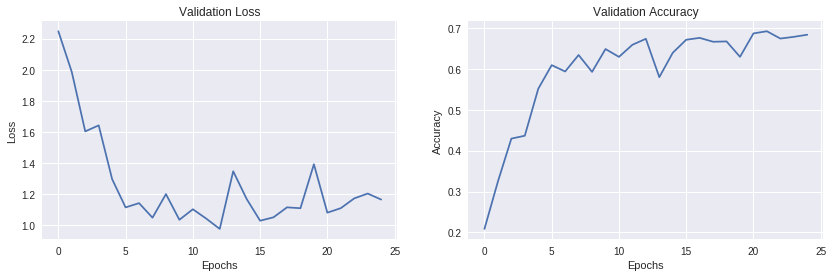

In [ ]:
# Validation
plot(history.history['val_loss'], 
     history.history['val_sparse_categorical_accuracy'], 
     subplot_title=['Validation Loss', 'Validation Accuracy']
    )

# Test accuracy

Next, we plot the model predictions on test set

In [ ]:
idxs = np.random.randint(x_test.shape[0], size=25)
images = x_test[idxs]
true_labels = y_test[idxs]

preds = np.argmax(model.predict(images), axis=1)

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = preds[i]
  color = 'g' if idx == true_labels[i] else 'r'
  ax.set_title(classnames[idx], color=color)

plt.show()

Next, you can see how to train the model on TPU <a href="https://colab.research.google.com/drive/1rP91Q5L1mPOVt7FcKkqFJSIMZrBtDawO">here</a>